## importing libraries

In [1]:
import os
import json
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from transformers import DetrImageProcessor, DetrForObjectDetection
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
from torchmetrics.detection.mean_ap import MeanAveragePrecision


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
DATA_PATH = "data/Fisheye8K_all_including_train&test"

TRAIN_IMAGE_DIR = os.path.join(DATA_PATH, 'train', 'images')
TRAIN_ANNOT_FILE = os.path.join(DATA_PATH, 'train', 'train.json')
TEST_IMAGE_DIR = os.path.join(DATA_PATH, 'test', 'images')
TEST_ANNOT_FILE = os.path.join(DATA_PATH, 'test', 'test.json')

print("Paths are set up correctly:")
print(f"Train Images: {TRAIN_IMAGE_DIR}")
print(f"Train Annotations: {TRAIN_ANNOT_FILE}")
print(f"Test Images: {TEST_IMAGE_DIR}")
print(f"Test Annotations: {TEST_ANNOT_FILE}")

Paths are set up correctly:
Train Images: data/Fisheye8K_all_including_train&test/train/images
Train Annotations: data/Fisheye8K_all_including_train&test/train/train.json
Test Images: data/Fisheye8K_all_including_train&test/test/images
Test Annotations: data/Fisheye8K_all_including_train&test/test/test.json


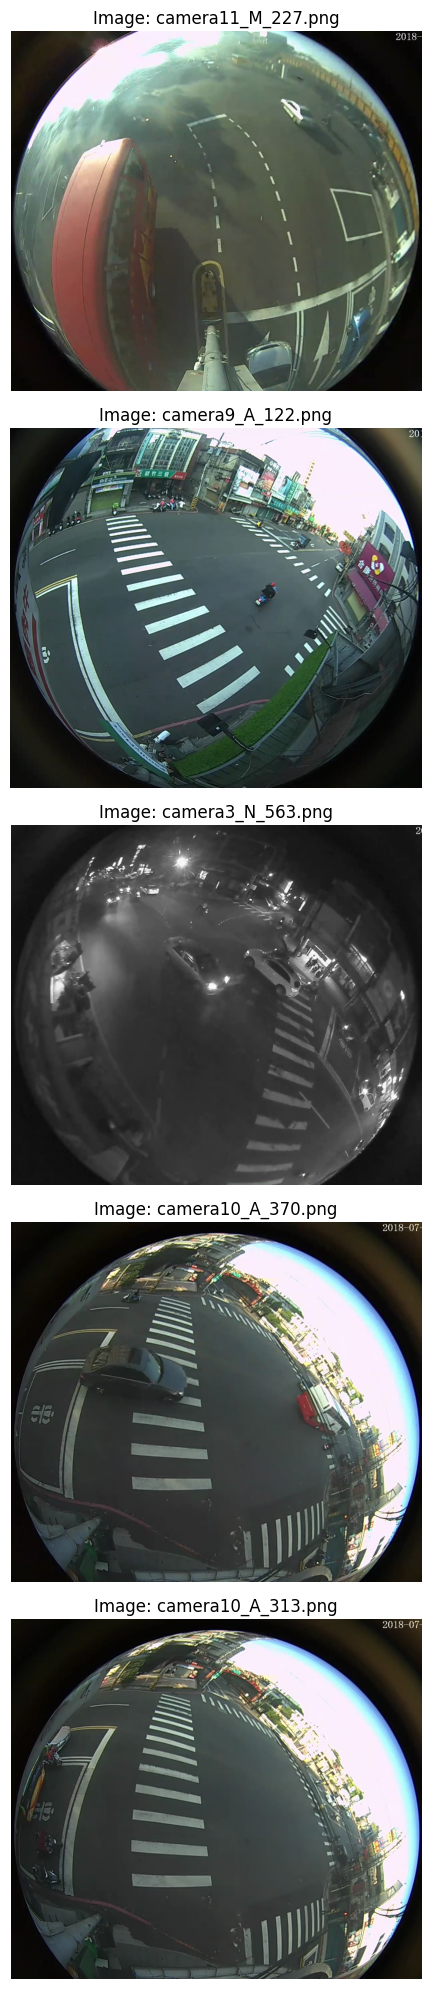

In [4]:
# Visualize random training images
imgs = os.listdir(TRAIN_IMAGE_DIR)
rand_imgs = np.random.choice(imgs, 5)

fig, ax = plt.subplots(5, 1, figsize=(10, 20))

for i, axes in enumerate(ax): 
    img = np.array(Image.open(os.path.join(TRAIN_IMAGE_DIR, rand_imgs[i])))
    axes.imshow(img)
    axes.set_title(f"Image: {rand_imgs[i]}")
    axes.axis('off')
    
plt.tight_layout()
plt.show()

In [5]:
class CocoDetectionDataset(Dataset):
    def __init__(self, image_dir, annot_file, processor):
        self.image_dir = image_dir
        self.coco = COCO(annot_file)
        self.processor = processor
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        coco_annotations = self.coco.loadAnns(ann_ids)
        
        img_info = self.coco.loadImgs(img_id)[0]
        path = img_info['file_name']
        image = Image.open(os.path.join(self.image_dir, path)).convert('RGB')

        target = {
            'image_id': img_id, 
            'annotations': coco_annotations, 
        }
        
        encoding = self.processor(images=image, annotations=target, return_tensors="pt")
        
        pixel_values = encoding["pixel_values"].squeeze()
        labels = encoding["labels"][0]

        return {"pixel_values": pixel_values, "labels": labels}

print("\nCorrected CocoDetectionDataset class defined.")


Corrected CocoDetectionDataset class defined.


In [6]:
from torch.utils.data import Dataset, DataLoader, random_split

# Load the processor from a pre-trained DETR model
model_checkpoint = "facebook/detr-resnet-50"
image_processor = DetrImageProcessor.from_pretrained(model_checkpoint)

full_train_dataset = CocoDetectionDataset(
    image_dir=TRAIN_IMAGE_DIR,
    annot_file=TRAIN_ANNOT_FILE,
    processor=image_processor
)
print(f"Full dataset loaded with {len(full_train_dataset)} examples.")

# Now, split the full dataset into training and validation sets (e.g., 80/20 split)
VAL_SPLIT_RATIO = 0.2
train_size = int((1 - VAL_SPLIT_RATIO) * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Use a generator for a reproducible split
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size], generator=generator)

print("\nDataset split complete:")
print(f"Number of training examples:   {len(train_dataset)}")
print(f"Number of validation examples: {len(val_dataset)}")

loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
Full dataset loaded with 5288 examples.

Dataset split complete:
Number of training examples:   4230
Number of validation examples: 1058


In [7]:
with open(TRAIN_ANNOT_FILE, 'r') as f:
    coco_data = json.load(f)
categories = coco_data['categories']
id2label = {cat['id']: cat['name'] for cat in categories}
label2id = {v: k for k, v in id2label.items()}

model = DetrForObjectDetection.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
).to(device)

print(f"\nModel loaded and configured for {len(id2label)} classes.")

/home/sreek27/dl-proj/aicitychallenge1/env/lib/python3.12/site-packages/torch/nn/modules/module.py:2409: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/home/sreek27/dl-proj/aicitychallenge1/env/lib/python3.12/site-packages/torch/nn/modules/module.py:2409: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/home/sreek27/dl-proj/aicitychallenge1/env/lib/python3.12/site-packages/torch/nn/modules/module.py:2409: UserWarning: for bn1.bias: copying from a non-meta parameter in


Model loaded and configured for 5 classes.


In [13]:
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 5
BATCH_SIZE = 16

# Since the Dataset class now handles formatting, the collate_fn is much simpler.
# Its only job is to pad images and move the batch to the device.
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    
    batch_dict = {}
    batch_dict['pixel_values'] = encoding['pixel_values'].to(device)
    batch_dict['pixel_mask'] = encoding['pixel_mask'].to(device)
    model_labels = [{k: v.to(device) for k, v in t.items()} for t in labels]
    batch_dict['labels'] = model_labels

    metric_labels = []
    for t in labels:
        metric_label = {k: v.to(device) for k, v in t.items()}
        metric_label['labels'] = metric_label.pop('class_labels')
        metric_labels.append(metric_label)
    batch_dict['metric_labels'] = metric_labels

    return batch_dict

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True) 
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True) 

print("\nManual training setup is complete.")


Manual training setup is complete.


In [14]:
from torch.cuda.amp import GradScaler, autocast 

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scaler = GradScaler() 

best_map = 0.0
history = {
    'train_loss': [], 'val_map': [], 'val_map_50': [], 'val_map_75': [],
}
best_model_path = "./project_weights_govindsr_atembulk_motorabs"

for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch + 1}/{NUM_EPOCHS} ---")
    
    # Training phase
    model.train()
    train_loss = 0
    progress_bar = tqdm(train_dataloader, desc="Training")
    
    for batch in progress_bar:
        # Use autocast for mixed precision
        with autocast(): 
            outputs = model(
                pixel_values=batch['pixel_values'],
                pixel_mask=batch['pixel_mask'],
                labels=batch['labels']  
            )
            loss = outputs.loss
        
        # Scale loss and backpropagate
        scaler.scale(loss).backward()
        scaler.step(optimizer) 
        scaler.update()
        optimizer.zero_grad()
        
        train_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
        
    avg_train_loss = train_loss / len(train_dataloader)
    history['train_loss'].append(avg_train_loss)
    print(f"Average Training Loss: {avg_train_loss:.4f}")

    # Evaluation phase
    model.eval()
    metric = MeanAveragePrecision(box_format='xywh', class_metrics=True).to(device)

    print("Evaluating...")
    for batch in tqdm(val_dataloader, desc="Evaluating"):
        # No need for autocast in evaluation with no_grad
        with torch.no_grad():
            outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

        orig_sizes = torch.stack([t['orig_size'] for t in batch['metric_labels']]).to(device)
        processed_preds = image_processor.post_process_object_detection(outputs, target_sizes=orig_sizes)
        
        metric.update(processed_preds, batch['metric_labels'])

    results = metric.compute()
    current_map = results['map'].item()

    history['val_map'].append(current_map)
    history['val_map_50'].append(results['map_50'].item())
    history['val_map_75'].append(results['map_75'].item())

    print(f"Validation mAP: {current_map:.4f}")
    print(f"Validation mAP_50: {results['map_50'].item():.4f}")
    print(f"Validation mAP_75: {results['map_75'].item():.4f}")

    if current_map > best_map:
        best_map = current_map
        print(f"New best model found with mAP: {best_map:.4f}! Saving to {best_model_path}")
        model.save_pretrained(best_model_path)
        image_processor.save_pretrained(best_model_path)
        
print("\nTraining complete!")


--- Epoch 1/5 ---


/tmp/ipykernel_306662/2560211242.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Training:   0%|          | 0/265 [00:00<?, ?it/s]

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/sreek27/dl-proj/aicitychallenge1/env/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/sreek27/dl-proj/aicitychallenge1/env/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_306662/1895421265.py", line 14, in collate_fn
    batch_dict['pixel_values'] = encoding['pixel_values'].to(device)
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sreek27/dl-proj/aicitychallenge1/env/lib/python3.12/site-packages/torch/cuda/__init__.py", line 358, in _lazy_init
    raise RuntimeError(
RuntimeError: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


In [ ]:
# trainer.train()

# # Save the final best model and processor
# final_model_path = "./detr-fisheye8k-final-best"
# trainer.save_model(final_model_path)
# image_processor.save_pretrained(final_model_path)

# print(f"Training complete! Best DETR model saved to {final_model_path}")